<a href="https://colab.research.google.com/github/kresdev/SCA-DP/blob/master/SCA_DP_with_PyTorch_colab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning SCA with PyTorch

In [1]:
import os
import os.path
import sys
import h5py
import torch
from tqdm.notebook import trange, tqdm

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
#if you are running in Google Colab you can use this function for check available GPU. T4 or p100 are better than Tesla K80

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15156750268258923691, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13392422402356655788
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6602459168071471075
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13868133248
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13217093898623089912
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## Generate Label for Traces

### Prepare ASCAD Code and Database

In [3]:
os.makedirs("ASCAD", exist_ok=True)

In [4]:
cd ASCAD

/content/ASCAD


In [5]:
#download ASCAD Database : ATMEGA8515 Masking Fixed Key
!wget https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip

--2020-08-02 14:56:41--  https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.93
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4435199469 (4.1G) [application/zip]
Saving to: ‘ASCAD_data.zip’

ASCAD_data.zip      100%[===================>]   4.13G  9.78MB/s    in 7m 14s  

2020-08-02 15:03:57 (9.75 MB/s) - ‘ASCAD_data.zip’ saved [4435199469/4435199469]



In [6]:
!unzip ASCAD_data.zip

Archive:  ASCAD_data.zip
   creating: ASCAD_data/
   creating: ASCAD_data/ASCAD_databases/
  inflating: ASCAD_data/ASCAD_databases/ASCAD.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync100.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync50.h5  
  inflating: ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5  
   creating: ASCAD_data/ASCAD_trained_models/
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync0_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync100_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync50_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best_ascad_desync0_node200_layernb6_epochs200_classes256_batchsize100.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best_ascad_desync100_node200_layernb6_epochs200_classes256_batchsize100.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best

### Download Model Example

In [7]:
#download model from gdrive
!pip install gdown

In [8]:
os.makedirs("ASCAD_data/ASCAD_model", exist_ok=True)

In [10]:
cd ASCAD_data/ASCAD_model

/content/ASCAD/ASCAD_data/ASCAD_model


In [11]:
!gdown https://drive.google.com/uc?id=1-BLlCkouiJwwbKlmDNRVy1UF33XKBIDZ

Downloading...
From: https://drive.google.com/uc?id=1-BLlCkouiJwwbKlmDNRVy1UF33XKBIDZ
To: /content/ASCAD/ASCAD_data/ASCAD_model/weights.pth
267MB [00:06, 43.8MB/s]


In [12]:
cd ../../

/content/ASCAD


## Preprocess Traces (Labeling)

In [13]:
in_file       = h5py.File("ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5", "r")

raw_traces    = in_file['traces']
raw_metadata  = in_file['metadata']

raw_plaintext = raw_metadata['plaintext']
raw_key       = raw_metadata['key']

In [14]:
num_traces_profiling_start  = 0
num_traces_profiling_stop   = 50000  
num_traces_attack_start     = 50000
num_traces_attack_stop      = 60000
point_interest_start        = 45400
point_interest_stop         = 46100

profiling_index   = [n for n in range(num_traces_profiling_start, num_traces_profiling_stop)]
attack_index      = [n for n in range(num_traces_attack_start, num_traces_attack_stop)]
target_point      = [n for n in range(point_interest_start, point_interest_stop)]

In [15]:
#make array for traces and metadatas

raw_traces_profiling    = np.zeros([len(profiling_index), len(target_point)], raw_traces.dtype)
label_profiling         = np.zeros(len(profiling_index), np.uint32)

raw_traces_attack       = np.zeros([len(attack_index), len(target_point)], raw_traces.dtype)
label_attack            = np.zeros(len(attack_index), np.uint32)

raw_traces_profiling.shape, label_profiling.shape, raw_traces_attack.shape, label_attack.shape

((50000, 700), (50000,), (10000, 700), (10000,))

In [16]:
idx_traces = 0
for traces in tqdm(profiling_index):
  np.copyto(raw_traces_profiling[idx_traces], raw_traces[traces, point_interest_start:point_interest_stop])
  idx_traces += 1

idx_traces = 0
for traces in tqdm(attack_index):
  np.copyto(raw_traces_attack[idx_traces], raw_traces[traces, point_interest_start:point_interest_stop])
  idx_traces += 1

raw_traces_profiling.shape, raw_traces_attack.shape

((50000, 700), (10000, 700))

In [17]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [18]:
#make labelize function
def labelize(plaintexts, keys, byte_attacked):
  return AES_Sbox[plaintexts[:, byte_attacked-1] ^ keys[:, byte_attacked-1]]

In [19]:
#byte attacked
byte_attacked = 3


labels_profiling  = labelize(raw_plaintext[profiling_index], raw_key[profiling_index], byte_attacked)
labels_attack     = labelize(raw_plaintext[attack_index], raw_key[attack_index], byte_attacked)

labels_profiling.shape, labels_attack.shape

((50000,), (10000,))

In [20]:
#make output to h5 file

out_file    = h5py.File("ASCAD_data/ASCAD_databases/ASCAD_New.h5", "w")

profiling_traces_group  = out_file.create_group("Profiling_traces")
attack_traces_group     = out_file.create_group("Attack_traces")

profiling_traces_group.create_dataset(name="traces", data=raw_traces_profiling, dtype=raw_traces_profiling.dtype)
attack_traces_group.create_dataset(name="traces", data=raw_traces_attack, dtype=raw_traces_attack.dtype)

profiling_traces_group.create_dataset(name="labels", data=labels_profiling, dtype=labels_profiling.dtype)
attack_traces_group.create_dataset(name="labels", data=labels_attack, dtype=labels_attack.dtype)

metadata_type = np.dtype([
                          ("plaintext", raw_plaintext.dtype, (len(raw_plaintext[0]), )),
                          ("key", raw_key.dtype, (len(raw_key[0]), )),
])

profiling_metadata = np.array([(raw_plaintext[n], raw_key[n]) for n in profiling_index], dtype=metadata_type)
profiling_traces_group.create_dataset("metadata", data=profiling_metadata, dtype=metadata_type)

attack_metadata = np.array([(raw_plaintext[n], raw_key[n]) for n in attack_index], dtype=metadata_type)
attack_traces_group.create_dataset("metadata", data=attack_metadata, dtype=metadata_type)

out_file.flush()
out_file.close()

# Deep Learning Section

## 1. Preparation Phase

### Import Traces and metadata Files

In [21]:
in_file = h5py.File("ASCAD_data/ASCAD_databases/ASCAD_New.h5")
X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
Y_profiling = np.array(in_file['Profiling_traces/labels'])

# data musbt be reshape to fit models (batch, channel, length)
X_profiling = X_profiling.reshape((X_profiling.shape[0], 1, X_profiling.shape[1]))

X_profiling.shape, Y_profiling.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


((50000, 1, 700), (50000,))

#### Convert data to tensor

In [22]:
X_profiling = torch.FloatTensor(X_profiling).to(device) 
Y_profiling = torch.LongTensor(Y_profiling).to(device) 

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


#### Set Dataset and Dataloader

In [23]:
#set batchsize for training phase
bs_train = 200

train_set = TensorDataset(X_profiling, Y_profiling)
trainloader = DataLoader(train_set, batch_size=bs_train, shuffle=True, num_workers=0)

### Architect and Config

In [24]:
#this model based on ASCAD on https://github.com/ANSSI-FR/ASCAD with PyTorch implementation modification
class CNNV16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            
            #block 1
            nn.Conv1d(1, 64, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 2
            nn.Conv1d(64, 128, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 3
            nn.Conv1d(128, 256, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
        
            #block 4
            nn.Conv1d(256, 512, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 5
            nn.Conv1d(512, 512, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            nn.Flatten()
        ) 
        
        
        self.fc = nn.Sequential(
            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

## 2. Training Phase

### Set Model for Training and Test Preparation

In [25]:
model = CNNV16().to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00001)
# optimizer = optim.AdamW(model.parameters(), lr=0.00001)

### Training Start

In [93]:
epochs = 75
train_cost, train_acc = [], []
for i in range(epochs):
    model.train()
    cost = correct = 0
    for feature, target in  tqdm(trainloader):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) #feedforward
        loss = criterion(output, target)
        loss.backward() #backprop

        optimizer.step() #update weight
        optimizer.zero_grad()
        

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    
    train_cost.append(cost / len(train_set))
    train_acc.append(correct/len(train_set))
        
    
    print(f"\rEpoch: {i+1}/{epochs:4} | train_cost : {train_cost[-1]:.4f} | train_acc : {train_acc[-1]:.4f}", end=" ")


Epoch: 1/  75 | train_cost : 5.5455 | train_acc : 0.0047 


Epoch: 2/  75 | train_cost : 5.5444 | train_acc : 0.0049 


Epoch: 3/  75 | train_cost : 5.5439 | train_acc : 0.0049 


Epoch: 4/  75 | train_cost : 5.5435 | train_acc : 0.0049 


Epoch: 5/  75 | train_cost : 5.5434 | train_acc : 0.0049 


Epoch: 6/  75 | train_cost : 5.5433 | train_acc : 0.0049 


Epoch: 7/  75 | train_cost : 5.5432 | train_acc : 0.0047 


Epoch: 8/  75 | train_cost : 5.5432 | train_acc : 0.0047 


Epoch: 9/  75 | train_cost : 5.5431 | train_acc : 0.0046 


Epoch: 10/  75 | train_cost : 5.5431 | train_acc : 0.0049 


Epoch: 11/  75 | train_cost : 5.5431 | train_acc : 0.0049 


Epoch: 12/  75 | train_cost : 5.5430 | train_acc : 0.0048 


Epoch: 13/  75 | train_cost : 5.5429 | train_acc : 0.0049 


Epoch: 14/  75 | train_cost : 5.5429 | train_acc : 0.0047 


Epoch: 15/  75 | train_cost : 5.5429 | train_acc : 0.0049 


Epoch: 16/  75 | train_cost : 5.5429 | train_acc : 0.0049 


Epoch: 17/  75 | train_cost : 5.5428 | train_acc : 0.0049 


Epoch: 18/  75 | train_cost : 5.5427 | train_acc : 0.0048 


Epoch: 19/  75 | train_cost : 5.5425 | train_acc : 0.0048 


Epoch: 20/  75 | train_cost : 5.5423 | train_acc : 0.0052 


Epoch: 21/  75 | train_cost : 5.5419 | train_acc : 0.0049 


Epoch: 22/  75 | train_cost : 5.5410 | train_acc : 0.0052 


Epoch: 23/  75 | train_cost : 5.5400 | train_acc : 0.0056 


Epoch: 24/  75 | train_cost : 5.5383 | train_acc : 0.0059 


Epoch: 25/  75 | train_cost : 5.5362 | train_acc : 0.0058 


Epoch: 26/  75 | train_cost : 5.5330 | train_acc : 0.0058 


Epoch: 27/  75 | train_cost : 5.5285 | train_acc : 0.0067 


Epoch: 28/  75 | train_cost : 5.5223 | train_acc : 0.0071 


Epoch: 29/  75 | train_cost : 5.5134 | train_acc : 0.0073 


Epoch: 30/  75 | train_cost : 5.4997 | train_acc : 0.0084 


Epoch: 31/  75 | train_cost : 5.4797 | train_acc : 0.0097 


Epoch: 32/  75 | train_cost : 5.4547 | train_acc : 0.0107 


Epoch: 33/  75 | train_cost : 5.4257 | train_acc : 0.0126 


Epoch: 34/  75 | train_cost : 5.4008 | train_acc : 0.0131 


Epoch: 35/  75 | train_cost : 5.3774 | train_acc : 0.0145 


Epoch: 36/  75 | train_cost : 5.3546 | train_acc : 0.0154 


Epoch: 37/  75 | train_cost : 5.3324 | train_acc : 0.0162 


Epoch: 38/  75 | train_cost : 5.3085 | train_acc : 0.0173 


Epoch: 39/  75 | train_cost : 5.2849 | train_acc : 0.0194 


Epoch: 40/  75 | train_cost : 5.2618 | train_acc : 0.0209 


Epoch: 41/  75 | train_cost : 5.2366 | train_acc : 0.0223 


Epoch: 42/  75 | train_cost : 5.2069 | train_acc : 0.0242 


Epoch: 43/  75 | train_cost : 5.1810 | train_acc : 0.0261 


Epoch: 44/  75 | train_cost : 5.1488 | train_acc : 0.0283 


Epoch: 45/  75 | train_cost : 5.1192 | train_acc : 0.0301 


Epoch: 46/  75 | train_cost : 5.0830 | train_acc : 0.0330 


Epoch: 47/  75 | train_cost : 5.0454 | train_acc : 0.0360 


Epoch: 48/  75 | train_cost : 5.0106 | train_acc : 0.0393 


Epoch: 49/  75 | train_cost : 4.9653 | train_acc : 0.0422 


Epoch: 50/  75 | train_cost : 4.9255 | train_acc : 0.0450 


Epoch: 51/  75 | train_cost : 4.8810 | train_acc : 0.0500 


Epoch: 52/  75 | train_cost : 4.8320 | train_acc : 0.0547 


Epoch: 53/  75 | train_cost : 4.7812 | train_acc : 0.0598 


Epoch: 54/  75 | train_cost : 4.7332 | train_acc : 0.0631 


Epoch: 55/  75 | train_cost : 4.6785 | train_acc : 0.0688 


Epoch: 56/  75 | train_cost : 4.6205 | train_acc : 0.0744 


Epoch: 57/  75 | train_cost : 4.5611 | train_acc : 0.0824 


Epoch: 58/  75 | train_cost : 4.5019 | train_acc : 0.0874 


Epoch: 59/  75 | train_cost : 4.4388 | train_acc : 0.0942 


Epoch: 60/  75 | train_cost : 4.3745 | train_acc : 0.0990 


Epoch: 61/  75 | train_cost : 4.3071 | train_acc : 0.1096 


Epoch: 62/  75 | train_cost : 4.2396 | train_acc : 0.1164 


Epoch: 63/  75 | train_cost : 4.1642 | train_acc : 0.1289 


Epoch: 64/  75 | train_cost : 4.0863 | train_acc : 0.1374 


Epoch: 65/  75 | train_cost : 4.0231 | train_acc : 0.1441 


Epoch: 66/  75 | train_cost : 3.9406 | train_acc : 0.1580 


Epoch: 67/  75 | train_cost : 3.8651 | train_acc : 0.1642 


Epoch: 68/  75 | train_cost : 3.7833 | train_acc : 0.1766 


Epoch: 69/  75 | train_cost : 3.7015 | train_acc : 0.1898 


Epoch: 70/  75 | train_cost : 3.6196 | train_acc : 0.2045 


Epoch: 71/  75 | train_cost : 3.5348 | train_acc : 0.2168 


Epoch: 72/  75 | train_cost : 3.4520 | train_acc : 0.2276 


Epoch: 73/  75 | train_cost : 3.3652 | train_acc : 0.2420 


Epoch: 74/  75 | train_cost : 3.2782 | train_acc : 0.2560 


Epoch: 75/  75 | train_cost : 3.1904 | train_acc : 0.2706 

### Save Model

In [98]:
os.makedirs("ASCAD_data/ASCAD_model", exist_ok=True)

In [99]:
torch.save(model.state_dict(), "ASCAD_data/ASCAD_model/weights_3.pth")

In [100]:
log = {
    "train_cost": train_cost,
    "train_acc": train_acc,
}
torch.save(log, "ASCAD_data/ASCAD_model/logs_3.pth")

## 3. Retrieve Key Phase

### Load Model

In [26]:
weights = torch.load("ASCAD_data/ASCAD_model/weights.pth", map_location="cpu")

In [27]:
model = CNNV16().to(device)
model.load_state_dict(weights)
model = model.to(device)

In [28]:
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

### Data Preparation

In [29]:
#num of traces for test
num_traces_test = 5000

in_file           = h5py.File("ASCAD_data/ASCAD_databases/ASCAD_New.h5")
X_attack          = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
metadata_attack   = np.array(in_file['Attack_traces/metadata'])

#reshape traces to num traces test

X_attack          = X_attack[:num_traces_test]
plainText_attack  = metadata_attack['plaintext'][:num_traces_test]
key_attack        = metadata_attack['key'][:num_traces_test]

X_attack = X_attack.reshape((X_attack.shape[0], 1, X_attack.shape[1]))

X_attack.shape, plainText_attack.shape, key_attack.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


((5000, 1, 700), (5000, 16), (5000, 16))

In [30]:
#batch size for test
bs_test = 200

X_attack          = torch.FloatTensor(X_attack).to(device) 
plainText_attack  = torch.IntTensor(plainText_attack).to(device)
key_attack        = torch.IntTensor(key_attack).to(device)

test_set          = TensorDataset(X_attack, plainText_attack, key_attack)
testloader        = DataLoader(test_set, batch_size=bs_test, shuffle=False)

In [31]:
# get key byte 3 from metadata
byte_attacked = 3

real_key = key_attack[0][byte_attacked-1]
real_key = real_key.item()
real_key

224

### Test Start

In [32]:
P_k = np.zeros(256)
traces_num = []
rank_traces = []
num_start = 0

for feature, plaintext, key in  tqdm(testloader):
    feature, plaintext, key = feature.to(device), plaintext.to(device), key.to(device)
    
    with torch.no_grad():
        model.eval()
        predictions = model(feature)

    for j in range(feature.shape[0]):

        # Test each key
        for k in range(256):
        
            pt = plaintext[j][byte_attacked-1].item()

            #find probability for specific first Sbox
            proba = predictions[j][AES_Sbox[pt ^ k]]

            # Add it to running total
            P_k[k] += proba


        traces_num.append(j+num_start)
        rank_traces.append(255-np.where(P_k.argsort() == real_key)[0])

    num_start = num_start+feature.shape[0]

### Plot Data

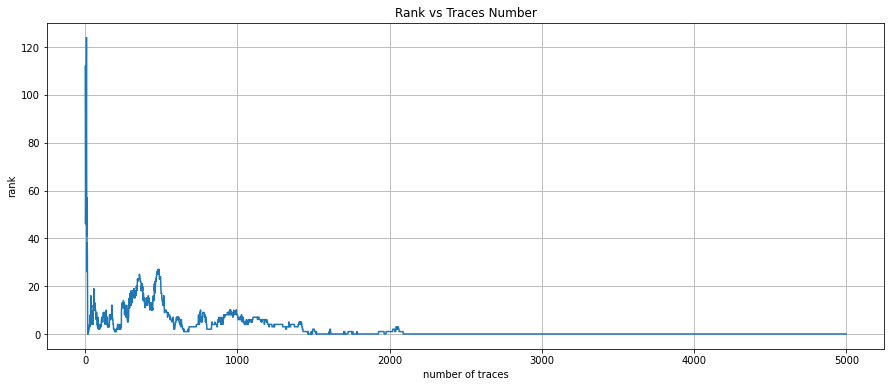

This is the key Guess:  0xe0 rank:  [0]
Attack succeed


In [33]:
plt.figure(figsize=(15, 6))
plt.title('Rank vs Traces Number')
plt.xlabel('number of traces')
plt.ylabel('rank')
plt.grid(True)
plt.plot(traces_num, rank_traces)
plt.show()

guess = P_k.argsort()[-1]
print("This is the key Guess: ", hex(guess), "rank: ", rank_traces[-1])
if(rank_traces[-1]==0):
    print("Attack succeed")
